Installing Dependencies

In [ ]:
# Importing Tensor Flow Module and Functions Within It
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten,  Dense, Dropout, MaxPooling2D, Conv2D
# Importing PLT For Graphing
import matplotlib.pyplot as plt
# Importing Module That Will Conduct Mathematical Operations On Arrays
import numpy as np
# Importing Pillow - Image Processor
from PIL import Image
import PIL
# Importing OS - Used To Navigate Through File Structures
import os

In [ ]:
# Setting The User To Use GPU - Prevents OOM Errors: Out Of Memory Error
device = tf.config.list_physical_devices('GPU')
# Printing The Current Device Being Used
print(device)

[]


Getting Datasets/Images And Removing Corrupt Files


In [ ]:
# Importing Drive / Where My Data Is Located
from google.colab import drive
drive.mount('/content/drive')
# Stating the Exact Data Directory
data_dir = '/content/drive/MyDrive/carsDataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Removing Dodgy Images


In [ ]:
import cv2 # Image Processing and Computer Vision Tasks Module
import imghdr # Module That Determines Image File Type
validFileTypes = ['jpeg', 'jpg', 'bmp', 'png'] # Listing File Types Allowed / Extensions

# Going Through Each Folder/Class In Dataset
for imageClass in os.listdir(data_dir):
  # Going Through Each Individual Image
  for image in os.listdir(os.path.join(data_dir, imageClass)):
    # Storing The Invidual Image In A Variable To Be Verified
    image_path = os.path.join(data_dir, imageClass, image)
    try:
      img = cv2.imread(image_path) # Getting The Image's NumPy N-dimensional Array
      fileType = imghdr.what(image_path) # Image File Type
      # Image Is Not In File Types Allowed
      if fileType not in validFileTypes:
        print(f'Image Not In EXT List {image_path}')
        # Removing Image From Dataset Within The Program (Not From Actual File)
        os.remove(image_path)
      # Stating There Is An Issue With The Image
    except Exception as e:
      print(f'Issue With Image {image_path}')
      os.remove(image_path)

Loading The Data

In [ ]:
# Storing All The Data Into A Variable - Resized Images To 256x256
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/carsDataset')
# The 5 Different Classes In The Car Class
carModel = ['Honda', 'Toyota', 'Lexus', 'Audi', 'BMW']

Found 56825 files belonging to 5 classes.


In [ ]:
# Acessing Data
data_iterator = data.as_numpy_iterator() # Numerical Form Of Data
batch = data_iterator.next() # Iterating To The Next Batch Of Data
batch[0] # Printing The First Batch

array([[[[ 39.98877   ,  40.123535  ,  48.078613  ],
         [ 42.035156  ,  43.125     ,  48.125     ],
         [ 41.04492   ,  41.04492   ,  49.04492   ],
         ...,
         [177.69458   , 172.56958   , 174.13208   ],
         [175.21204   , 169.21204   , 171.33704   ],
         [179.48169   , 169.79419   , 170.79419   ]],

        [[ 39.6875    ,  39.957886  ,  47.14673   ],
         [ 40.027466  ,  40.16223   ,  47.757935  ],
         [ 40.302734  ,  39.572266  ,  45.4375    ],
         ...,
         [161.8258    , 156.7008    , 158.2633    ],
         [170.92773   , 164.92773   , 167.05273   ],
         [176.14673   , 166.45923   , 167.45923   ]],

        [[ 35.543823  ,  34.543823  ,  40.543823  ],
         [ 41.346558  ,  40.298096  ,  48.44348   ],
         [ 42.21289   ,  41.21289   ,  47.21289   ],
         ...,
         [171.23792   , 166.11292   , 167.67542   ],
         [170.68518   , 164.68518   , 166.81018   ],
         [181.76367   , 172.07617   , 173.07617   ]],

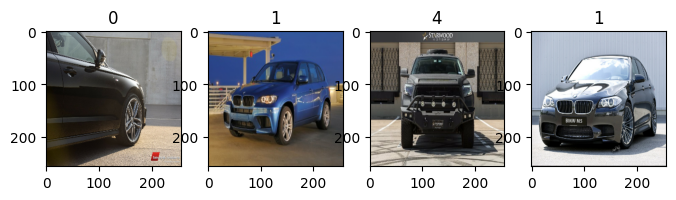

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(8,8)) # 4 Creating A Figure With 4 Figures With 8x8 Size
for idx, img in enumerate(batch[0][:4]): # Getting Last 4 Images From Batch 0
  ax[idx].imshow(img.astype(int)) # Showing The Images
  ax[idx].title.set_text(batch[1][idx]) # Stating Which Class The Image Is From

Normalizing the Data

In [ ]:
# Normalzing The Data
data = data.map(lambda x, y: (x/255, y)) # Performing Pixel Transformation To Range Of [0, 1] To Pipeline
scaled_iterator = data.as_numpy_iterator() # Grabbing The Next Batch
batch = scaled_iterator.next()
batch[0].max() # Testing If Max Value Is 1 - Which It Should Be If Images Are Transformed Correctly

1.0

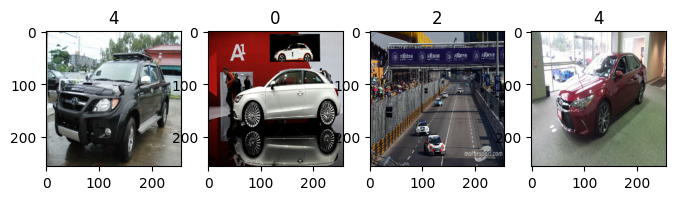

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(8,8)) # 4 Creating A Figure With 4 Figures With 8x8 Size
for idx, img in enumerate(batch[0][:4]): # Getting Last 4 Images From Batch 0
  ax[idx].imshow(img) # Showing The Images
  ax[idx].title.set_text(batch[1][idx]) # Stating Which Class The Image Is From

Partitioning The Dataset

In [ ]:
# Finding The Size For Each Dataset
data_size = len(data)
train_size = int(len(data)*0.7) # Around 70% Of Data For Train
val_size = int(len(data)*0.2)+1 # Around 20% Of Data For Validation
test_size = int(len(data)*0.1)+1 # Around 10% Of Data For Test
print(data_size, train_size, val_size, test_size)
# Used These Train Sizes Due To Overfitting In Model When Using Above Sizes
train_size = 7
val_size = 2
test_size = 1

1776 1243 356 178


In [ ]:
# Allocating Certain Amount Of Batches For Each Dataset Based On Above Calc.
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

CNN Structure

In [ ]:
class MyModel(keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    # 3 Convolutions And 2 Max Pooling
    self.conv1 = Conv2D(128, (3, 3), activation='relu', input_shape=(256, 256, 3))
    self.pool1 = MaxPooling2D((2, 2))
    self.conv2 = Conv2D(64, (3, 3), activation='relu')
    self.pool2 = MaxPooling2D((2, 2))
    self.conv3 =  Conv2D(32, (3, 3), activation='relu')
    # Flattening Output
    self.flatten = Flatten()
    # Densing Using Relu
    self.d1 = Dense(128, activation='relu')
    # Drop Out 1- Reduces Overfitting
    self.dropout = Dropout(0.5)
    # Densing Using SoftMax
    self.d2 = Dense(5, activation = 'softmax')

  # Performs Forward Pass Through The Layers Of The CNN Above
  def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.dropout(x)
        return self.d2(x)

Compiling The Model

In [ ]:
# Create an instance of the model
model = MyModel()

# Choosing An Optimizer And Loss Function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

# Compiling The Model While Making The Metrics To Be Accuracy
model.compile(optimizer, loss_object, metrics = 'accuracy')

Training & Storing Results

In [ ]:
# Creating A File To Save Training Logs
logdir = 'logs'
# Logging information about the training process
tensorboard_callbacks = tf.keras.callbacks.TensorBoard(log_dir = logdir)
# Trains the model for 20 epochs using the training set, and validates it using the validation set
hist = model.fit(train, epochs = 5, validation_data = val, callbacks = tensorboard_callbacks)


Epoch 1/5
7/7 [==============================] - 97s 14s/step - loss: 0.0416 - accuracy: 0.9911 - val_loss: 0.2234 - val_accuracy: 0.9375
Epoch 2/5
7/7 [==============================] - 95s 13s/step - loss: 0.0964 - accuracy: 0.9777 - val_loss: 0.4416 - val_accuracy: 0.8906
Epoch 3/5
7/7 [==============================] - 95s 13s/step - loss: 0.0589 - accuracy: 0.9777 - val_loss: 0.5165 - val_accuracy: 0.8906
Epoch 4/5
7/7 [==============================] - 103s 15s/step - loss: 0.0281 - accuracy: 0.9911 - val_loss: 0.6007 - val_accuracy: 0.8594
Epoch 5/5
7/7 [==============================] - 107s 16s/step - loss: 0.0400 - accuracy: 0.9821 - val_loss: 0.3583 - val_accuracy: 0.9531


Training Loss Graph


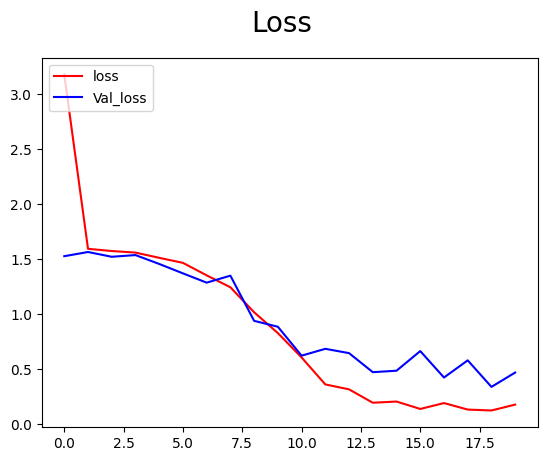

In [ ]:
# Creating A Variable To Make A Figure / Graph
fig = plt.figure()
# Acessing Loss From Recorded Logs From Previous Training
plt.plot(hist.history['loss'], color = 'red', label = 'loss'
# Acessing Loss From Recorded Logs From Previous Validation)
plt.plot(hist.history['val_loss'], color = 'blue', label = 'Val_loss')
# Creating The Figure Title As Loss
fig.suptitle('Loss', fontsize = 20)
# Stating Where The Key For The Graph Should Be Located
plt.legend(loc = "upper left")
# Showing The Graph
plt.show()

Training Accuracy Graph

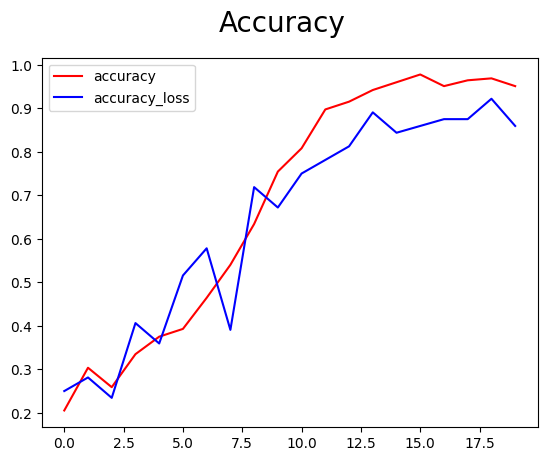

In [ ]:
# Creating A Variable To Make A Figure / Graph
fig = plt.figure()
# Acessing Accuracy From Recorded Logs From Previous Training
plt.plot(hist.history['accuracy'], color = 'red', label = 'accuracy')
# Acessing Accuracy From Recorded Logs From Previous Validation
plt.plot(hist.history['val_accuracy'], color = 'blue', label = 'accuracy_loss')
# Creating The Figure Title As Accuracy
fig.suptitle('Accuracy', fontsize = 20)
# Stating Where The Key For The Graph Should Be Located
plt.legend(loc = "upper left")
# Showing The Graph
plt.show()

Test

In [ ]:
testHist = model.evaluate(test)

1/1 [==============================] - 8s 8s/step - loss: 0.5149 - accuracy: 0.9062


Testing On A Random Image From The Net


In [ ]:
"""
Class 1 - Audi
Class 2 - BMW
Class 3 - Accord
Class 4 - Lexus
Class 5 - Toyota
"""

# Getting The Image From My Drive
newImage = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/TestImage') # Audi Car
# Predicting The Image
newTest = model.predict(newImage)
print(newTest) # Printing The Result

Found 1 files belonging to 1 classes.
1/1 [==============================] - 0s 406ms/step
[[1. 0. 0. 0. 0.]]
